In [1]:
pip install -U "transformers==4.46.2" "huggingface-hub==0.25.2" "httpx>=0.27.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 86.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

# PART 1: LIBRARY IMPORTS AND INITIAL SETUP

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as albu

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from transformers import AutoModel, AutoProcessor

import random
from IPython.display import display, Image as IPImage
from skimage import feature

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


2025-10-15 12:54:14.878174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760532855.058725      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760532855.110624      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# CONFIGURATION AND MODEL LOADING

In [3]:
print("Loading CLIP model and processor...")
clip_backbone = AutoModel.from_pretrained("apple/DFN5B-CLIP-ViT-H-14-378")
image_processor = AutoProcessor.from_pretrained("apple/DFN5B-CLIP-ViT-H-14-378")
print("CLIP model loaded successfully!")

Loading CLIP model and processor...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

CLIP model loaded successfully!


# DATA PATH CONFIGURATION

In [4]:
dataset_root_dir = os.path.join("/", "kaggle", "input", "ai-vs-human-generated-dataset")
train_csv_path = os.path.join(dataset_root_dir, "train.csv")
test_csv_path = os.path.join(dataset_root_dir, "test.csv")

# CUSTOM DATASET CLASS

In [5]:
class AIImageDetectionDataset(Dataset):
    """
    Custom PyTorch Dataset for AI vs Human Image Classification.
    
    This dataset loads images, applies transformations, and processes them
    through a CLIP processor for feature extraction.
    """
    
    def __init__(self, csv_path, root_dir, augmentations=None, 
                 clip_processor=None, mode='train'):
        """
        Initialize the dataset.
        
        Args:
            csv_path (str): Path to CSV file with image names and labels
            root_dir (str): Root directory containing images
            augmentations (albu.Compose): Albumentations transformation pipeline
            clip_processor (CLIPProcessor): CLIP processor for image preprocessing
            mode (str): 'train' or 'test' mode
        """      
        self.dataframe = pd.read_csv(csv_path)
        self.num_samples = len(self.dataframe)
        self.augmentations = augmentations
        self.clip_processor = clip_processor
        self.mode = mode
        self.root_dir = root_dir

        if mode == 'train':
            # Training mode: load image paths and labels
            self.image_paths = self.dataframe.iloc[:, 1].values
            label_array = self.dataframe.iloc[:, -1].values.astype(int)
            self.labels = torch.from_numpy(label_array).long()
        else:
            # Test mode: load only image paths
            self.image_paths = self.dataframe.iloc[:, 0].values
            self.labels = self.dataframe.iloc[:, 0].values

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return self.num_samples

    def __getitem__(self, index):
        """
        Load and return a single sample from the dataset.
        
        Args:
            index (int): Index of the sample to retrieve
            
        Returns:
            tuple: (processed_image, label) for training or (processed_image, image_id) for testing
        """
        # Load image from disk
        full_image_path = os.path.join(self.root_dir, self.image_paths[index])
        image = Image.open(full_image_path).convert('RGB')

        # Apply augmentations if specified
        if self.augmentations:
            image_array = np.array(image)
            augmented = self.augmentations(image=image_array)
            image = Image.fromarray(augmented['image'])

        # Process image through CLIP processor
        processed_images = []
        image_batch = [image]

        for img in image_batch:
            pixel_values = self.clip_processor(images=img, return_tensors="pt")['pixel_values']
            processed_images.append(pixel_values.squeeze(0))

        final_tensor = torch.cat(processed_images, dim=0)
        
        return final_tensor, self.labels[index]

# DATA AUGMENTATION PIPELINES

In [6]:
# Training augmentations: various transformations to improve generalization
training_augmentations = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
    albu.GaussianBlur(blur_limit=(7, 15), sigma_limit=(1.0, 2.0), p=0.3),
    albu.Affine(rotate=15, translate_percent=0.1, scale=(0.9, 1.1), shear=10, p=0.1),
    albu.ToGray(p=0.2),
])

# Validation/Test augmentations: no transformations for consistent evaluation
validation_augmentations = albu.Compose([])

# DATASET AND DATALOADER CREATION

In [7]:
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 64

print("\nCreating datasets...")
# Create full training dataset
full_training_dataset = AIImageDetectionDataset(
    csv_path=train_csv_path, 
    root_dir=dataset_root_dir, 
    augmentations=training_augmentations, 
    clip_processor=image_processor, 
    mode='train'
)

# Split training data into train and validation sets
train_split_size = int(0.998 * len(full_training_dataset))
val_split_size = len(full_training_dataset) - train_split_size

unused_train_set, validation_dataset = random_split(
    full_training_dataset, 
    [train_split_size, val_split_size]
)

# Create test dataset
test_dataset = AIImageDetectionDataset(
    csv_path=test_csv_path, 
    root_dir=dataset_root_dir, 
    augmentations=validation_augmentations, 
    clip_processor=image_processor, 
    mode='test'
)

print(f"Training samples: {len(full_training_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
train_dataloader = DataLoader(
    dataset=full_training_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

validation_dataloader = DataLoader(
    dataset=validation_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Creating datasets...
Training samples: 79950
Validation samples: 160
Test samples: 5540


# MODEL ARCHITECTURE

In [8]:
print("\nInitializing model...")
print('CUDA Available: ', torch.cuda.is_available())

computation_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CLIPTransformerClassifier(nn.Module):
    """
    AI Image Detection Classifier using CLIP backbone with Transformer layers.
    
    Architecture:
        - Frozen CLIP model for feature extraction
        - Fully connected layers with Transformer blocks
        - Multi-head attention for better feature learning
    """
    
    def __init__(self, clip_backbone_model, num_output_classes=2, 
                 freeze_backbone=True, clip_embedding_dim=1024):
        """
        Initialize the classifier.
        
        Args:
            clip_backbone_model: Pre-trained CLIP model
            num_output_classes (int): Number of classes (AI vs Human)
            freeze_backbone (bool): Whether to freeze CLIP weights
            clip_embedding_dim (int): Dimension of CLIP embeddings
        """
        super(CLIPTransformerClassifier, self).__init__()
        
        self.clip_backbone = clip_backbone_model
        
        # Freeze CLIP parameters to prevent overfitting
        if freeze_backbone:
            for param in self.clip_backbone.parameters():
                param.requires_grad = False
        
        self.embedding_dimension = clip_embedding_dim

        # First fully connected layer: reduce dimensionality
        self.fc_layer_1 = nn.Linear(self.embedding_dimension, 256)
        self.activation_relu = nn.ReLU()
        self.dropout_layer = nn.Dropout(0.1)
        
        # Second fully connected layer
        self.fc_layer_2 = nn.Linear(256, 64)
        
        # Output layer
        self.fc_output = nn.Linear(64, num_output_classes)

        # First Transformer block: operates on 256-dim features
        self.transformer_encoder_1 = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=4,
            dim_feedforward=512,
            dropout=0.2
        )

        # Second Transformer block: operates on 64-dim features
        self.transformer_encoder_2 = nn.TransformerEncoderLayer(
            d_model=64,
            nhead=4,
            dim_feedforward=128,
            dropout=0.2
        )
    
    def forward(self, pixel_values):
        """
        Forward pass through the network.
        
        Args:
            pixel_values: Processed image tensors
            
        Returns:
            torch.Tensor: Class logits (before softmax)
        """
        image_input = {'pixel_values': pixel_values}
        
        # Extract features from frozen CLIP model
        with torch.no_grad():
            clip_features = self.clip_backbone.get_image_features(**image_input)
        
        # First FC layer with activation and dropout
        hidden = self.fc_layer_1(clip_features)
        hidden = self.activation_relu(hidden)
        hidden = self.dropout_layer(hidden)

        # First Transformer block (requires sequence dimension)
        hidden = hidden.unsqueeze(0)  # Add sequence length dimension
        hidden = self.transformer_encoder_1(hidden)
        hidden = hidden.squeeze(0)  # Remove sequence length dimension
        
        # Second FC layer
        hidden = self.fc_layer_2(hidden)
        hidden = self.activation_relu(hidden)
        hidden = self.dropout_layer(hidden)

        # Second Transformer block
        hidden = hidden.unsqueeze(0)
        hidden = self.transformer_encoder_2(hidden)
        hidden = hidden.squeeze(0)

        # Output layer
        logits = self.fc_output(hidden)
        
        return logits

# Initialize model
classifier_model = CLIPTransformerClassifier(
    clip_backbone_model=clip_backbone, 
    num_output_classes=2, 
    freeze_backbone=True, 
    clip_embedding_dim=1024
)



Initializing model...
CUDA Available:  True


#  MODEL LOADING (if pre-trained weights exist)

In [9]:
LOAD_PRETRAINED_WEIGHTS = False
pretrained_model_path = os.path.join(
    "/", "kaggle", "input", "my-model-for-ai-image-detect", 
    "pytorch", "new_structure", "3", "temp_model.pth"
)

if LOAD_PRETRAINED_WEIGHTS and os.path.exists(pretrained_model_path):
    model_state_dict = torch.load(pretrained_model_path, map_location=computation_device)
    classifier_model.load_state_dict(model_state_dict, strict=False)
    print("✓ Loaded pre-trained model weights")
else:
    print("✓ Initialized model with random weights")

classifier_model = classifier_model.to(computation_device)

✓ Initialized model with random weights


# TRAINING CONFIGURATION

In [10]:

LEARNING_RATE = 1e-3

# Optimizer: Adam with weight decay for regularization
optimizer = Adam(
    classifier_model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=1e-2
)

# Learning rate scheduler: reduce LR every 20 epochs
lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.45)

# Loss function: Cross-entropy for binary classification
criterion = nn.CrossEntropyLoss()


#  TRAINING AND EVALUATION FUNCTIONS

In [11]:
# Track best F1 score across all epochs
best_validation_f1 = 0.0
NUM_TRAINING_EPOCHS = 1
gradient_scaler = GradScaler()

# Store training history for visualization
training_history = {
    'epoch_losses': [],
    'batch_losses': [],
    'validation_f1_scores': [],
    'learning_rates': []
}

def train_one_epoch(epoch_num, early_stop_patience=15):
    """
    Train the model for one epoch with early stopping capability.
    
    Args:
        epoch_num (int): Current epoch number
        early_stop_patience (int): Number of batches without improvement before stopping
        
    Returns:
        list: Loss values for each batch
    """
    classifier_model.train()
    cumulative_loss = 0.0
    batch_loss_history = []
    patience_counter = 0
    best_loss_so_far = 100.0
    
    progress_bar = tqdm(
        enumerate(train_dataloader), 
        desc=f'Training Epoch {epoch_num + 1}',
        total=len(train_dataloader)
    )
    
    for batch_idx, (image_batch, label_batch) in progress_bar:
        image_batch = image_batch.to(computation_device)
        label_batch = label_batch.to(computation_device)

        # Zero gradients
        optimizer.zero_grad()
        
        # Mixed precision training for faster computation
        with autocast():
            predictions = classifier_model(image_batch)
            loss = criterion(predictions, label_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        cumulative_loss += loss.item()
        lr_scheduler.step()

        # Log loss every 5 batches
        if batch_idx % 5 == 4:
            avg_loss = cumulative_loss / 5
            batch_loss_history.append(avg_loss)
            
            progress_bar.set_postfix({
                'loss': f'{avg_loss:.6f}',
                'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
            })
            
            # Save model if loss improved
            if avg_loss < best_loss_so_far:
                best_loss_so_far = avg_loss
                save_model_checkpoint('temp_checkpoint.pth')
            
            cumulative_loss = 0.0

            # Early stopping check
            if len(batch_loss_history) > 5:
                recent_min_loss = min(batch_loss_history[-5:])
                if batch_loss_history[-1] > recent_min_loss:
                    patience_counter += 1
                    if patience_counter > early_stop_patience:
                        print(f'\nEarly stopping triggered at batch {batch_idx}')
                        break
            
            # Gradually increase loss threshold to avoid stale checkpoints
            best_loss_so_far = best_loss_so_far + 0.002

    # Load best checkpoint from this epoch
    checkpoint_state = torch.load('temp_checkpoint.pth')
    classifier_model.load_state_dict(checkpoint_state, strict=False)
    
    return batch_loss_history

def evaluate_model():
    """
    Evaluate the model on validation set and compute metrics.
    
    Returns:
        tuple: (f1_score, all_true_labels, all_predictions)
    """
    classifier_model.eval()
    global best_validation_f1
    
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():
        for image_batch, label_batch in tqdm(validation_dataloader, desc='Validation'):
            image_batch = image_batch.to(computation_device)
            label_batch = label_batch.to(computation_device)
            
            with autocast():
                predictions = classifier_model(image_batch)
            
            _, predicted_classes = torch.max(predictions.data, dim=1)
            
            all_true_labels.extend(label_batch.cpu().numpy())
            all_predicted_labels.extend(predicted_classes.cpu().numpy())

    # Calculate F1 score
    f1_metric = f1_score(all_true_labels, all_predicted_labels, average='weighted')
    print(f'\n{"="*60}')
    print(f'Validation F1 Score: {f1_metric:.4f}')
    print(f'{"="*60}\n')

    # Save best model
    if f1_metric > best_validation_f1:
        best_validation_f1 = f1_metric
        save_model_checkpoint('best_model.pth')
        print(f'✓ New best model saved! F1 Score: {f1_metric:.4f}\n')
    
    return f1_metric, all_true_labels, all_predicted_labels

def save_model_checkpoint(checkpoint_name):
    """
    Save model state dict (excluding CLIP parameters).
    
    Args:
        checkpoint_name (str): Name of the checkpoint file
    """
    state_dict = classifier_model.state_dict()
    
    # Remove CLIP parameters to save space
    filtered_state_dict = {
        key: value for key, value in state_dict.items() 
        if not key.startswith('clip_backbone.')
    }
    
    torch.save(filtered_state_dict, checkpoint_name)


/tmp/ipykernel_19/224374233.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  gradient_scaler = GradScaler()


# VISUALIZATION FUNCTIONS

In [12]:
def plot_training_loss(loss_history, epoch_num):
    """
    Plot training loss progression over batches.
    
    Args:
        loss_history (list): List of loss values
        epoch_num (int): Current epoch number
    """
    plt.figure(figsize=(12, 6))
    plt.plot(loss_history, marker='o', linestyle='-', linewidth=2, markersize=4)
    plt.xlabel('Batch Index (every 5 batches)', fontsize=12)
    plt.ylabel('Average Loss', fontsize=12)
    plt.title(f'Training Loss Progress - Epoch {epoch_num + 1}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(true_labels, predictions, epoch_num):
    """
    Plot confusion matrix for validation predictions.
    
    Args:
        true_labels (list): Ground truth labels
        predictions (list): Model predictions
        epoch_num (int): Current epoch number
    """
    cm = confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Human', 'AI'], 
                yticklabels=['Human', 'AI'])
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix - Epoch {epoch_num + 1}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_classification_metrics(true_labels, predictions):
    """
    Print detailed classification report.
    
    Args:
        true_labels (list): Ground truth labels
        predictions (list): Model predictions
    """
    print("\nDetailed Classification Report:")
    print("="*60)
    report = classification_report(
        true_labels, predictions, 
        target_names=['Human', 'AI'], 
        digits=4
    )
    print(report)

def plot_training_history():
    """
    Plot comprehensive training history including loss and F1 scores.
    """
    if not training_history['epoch_losses']:
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot epoch losses
    axes[0].plot(training_history['epoch_losses'], marker='o', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Average Loss', fontsize=12)
    axes[0].set_title('Training Loss per Epoch', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Plot validation F1 scores
    axes[1].plot(training_history['validation_f1_scores'], 
                 marker='s', color='green', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('F1 Score', fontsize=12)
    axes[1].set_title('Validation F1 Score per Epoch', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# TRAINING LOOP


STARTING TRAINING


EPOCH 1/1




Training Epoch 1:   0%|          | 0/1250 [00:00<?, ?it/s]/tmp/ipykernel_19/224374233.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training Epoch 1:  12%|█▏        | 154/1250 [25:36<3:02:18,  9.98s/it, loss=0.164844, lr=0.000004]



Early stopping triggered at batch 154


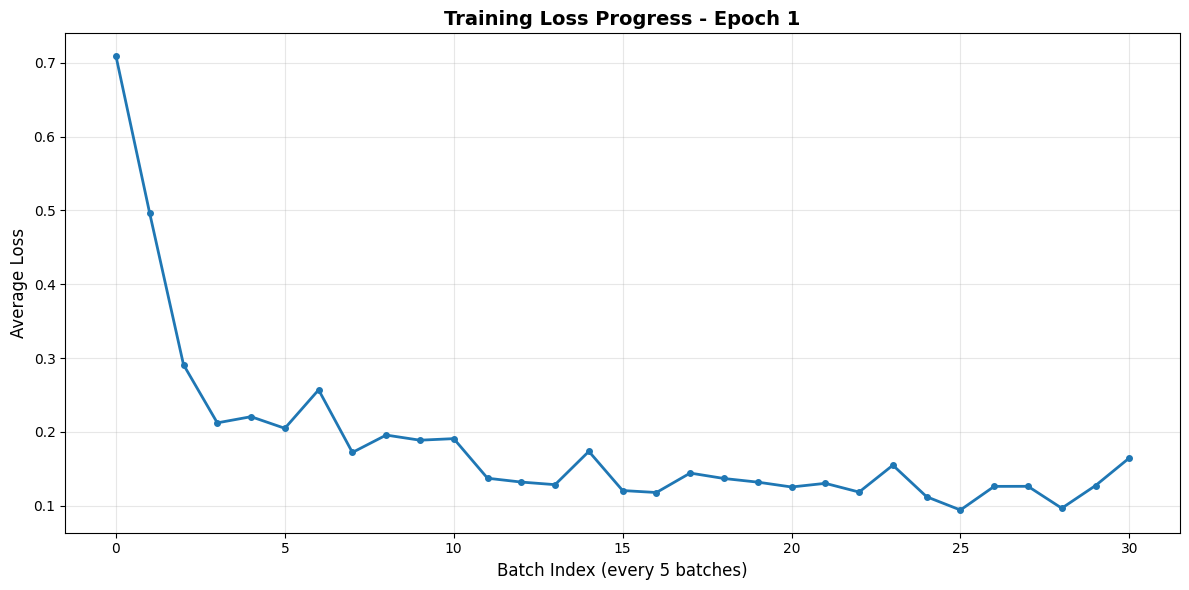

Validation:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_19/224374233.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 3/3 [00:27<00:00,  9.06s/it]



Validation F1 Score: 0.9813

✓ New best model saved! F1 Score: 0.9813



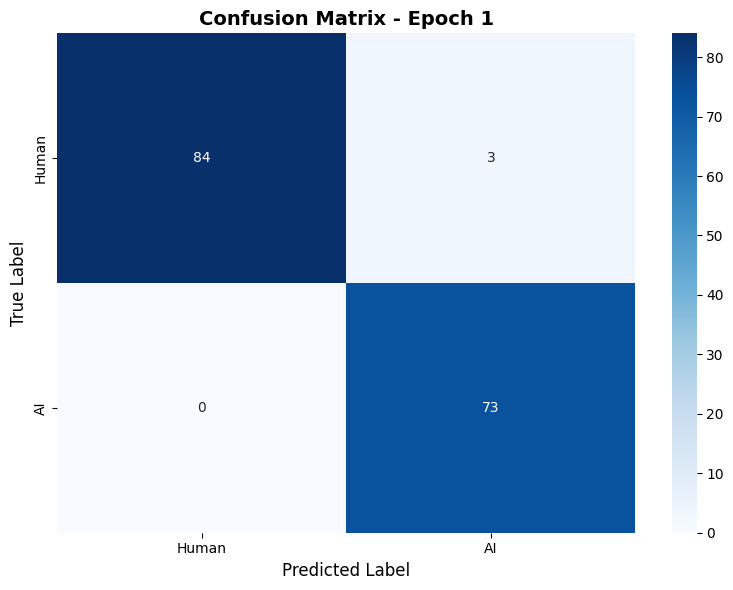


Detailed Classification Report:
              precision    recall  f1-score   support

       Human     1.0000    0.9655    0.9825        87
          AI     0.9605    1.0000    0.9799        73

    accuracy                         0.9812       160
   macro avg     0.9803    0.9828    0.9812       160
weighted avg     0.9820    0.9812    0.9813       160


TRAINING COMPLETE - Summary Visualizations



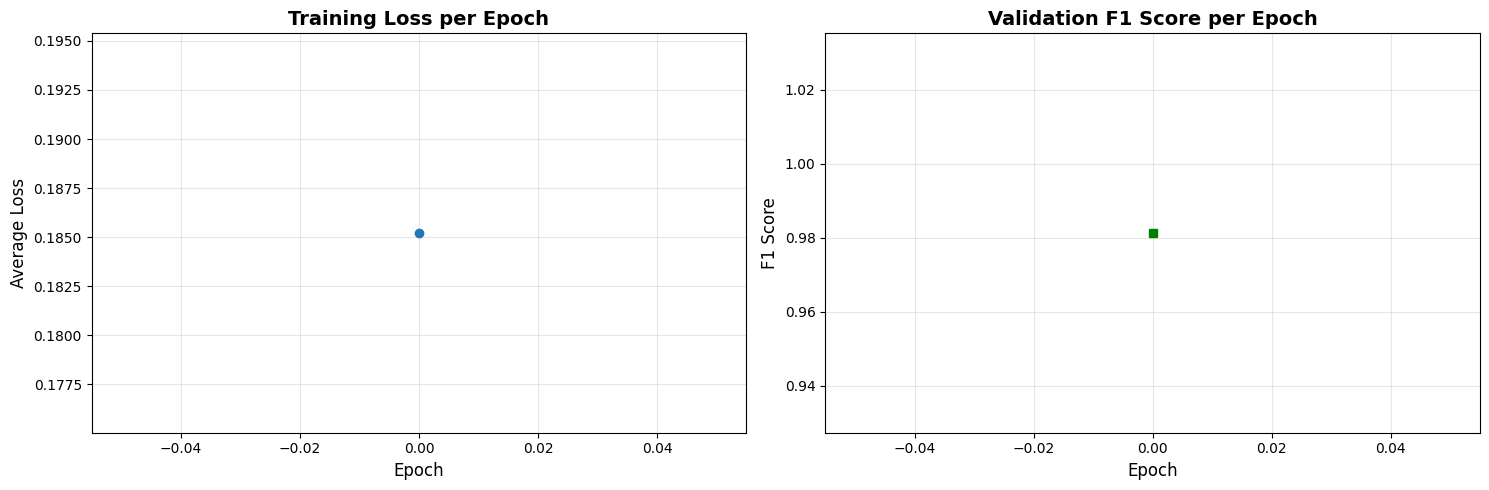

In [13]:

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

# Save initial model
save_model_checkpoint('best_model.pth')

if NUM_TRAINING_EPOCHS <= 0:
    print("Skipping training, evaluating current model...")
    evaluate_model()
else:
    for epoch_idx in range(NUM_TRAINING_EPOCHS):
        print(f"\n{'='*60}")
        print(f"EPOCH {epoch_idx + 1}/{NUM_TRAINING_EPOCHS}")
        print(f"{'='*60}\n")
        
        # Train for one epoch
        epoch_losses = train_one_epoch(epoch_num=epoch_idx, early_stop_patience=15)
        
        # Store average epoch loss
        if epoch_losses:
            avg_epoch_loss = np.mean(epoch_losses)
            training_history['epoch_losses'].append(avg_epoch_loss)
            training_history['learning_rates'].append(optimizer.param_groups[0]['lr'])
        
        # Visualize training loss
        plot_training_loss(epoch_losses, epoch_idx)
        
        # Evaluate model
        f1, true_labels, predictions = evaluate_model()
        training_history['validation_f1_scores'].append(f1)
        
        # Visualize validation results
        plot_confusion_matrix(true_labels, predictions, epoch_idx)
        plot_classification_metrics(true_labels, predictions)
    
    # Plot overall training history
    print("\n" + "="*60)
    print("TRAINING COMPLETE - Summary Visualizations")
    print("="*60 + "\n")
    plot_training_history()


# TEST SET INFERENCE

In [14]:
print("\n" + "="*60)
print("GENERATING TEST PREDICTIONS")
print("="*60 + "\n")

# Load best model for inference
best_model_state = torch.load('best_model.pth')
classifier_model.load_state_dict(best_model_state, strict=False)
classifier_model.to(computation_device)
classifier_model.eval()

test_predictions = []

with torch.no_grad():
    for batch_idx, (image_batch, image_ids) in enumerate(tqdm(test_dataloader, desc='Testing')):
        image_batch = image_batch.to(computation_device, non_blocking=True)
        
        with autocast():
            logits = classifier_model(image_batch)

        # Apply softmax to get probabilities
        probabilities = torch.softmax(logits, dim=-1)
        ai_class_probabilities = probabilities[:, 1].cpu().numpy()
        
        # Store predictions
        for img_id, prob in zip(image_ids, ai_class_probabilities):
            test_predictions.append((img_id, prob))
        
        if (batch_idx + 1) % 10 == 0:
            print(f"Processed: {batch_idx + 1}/{len(test_dataloader)} batches")

# Save probability predictions
probabilities_dataframe = pd.DataFrame(test_predictions, columns=["id", "ai_probability"])
probabilities_output_path = "test_probabilities.csv"
probabilities_dataframe.to_csv(probabilities_output_path, index=False)
print(f"\n✓ Probabilities saved to: {probabilities_output_path}")


GENERATING TEST PREDICTIONS



Testing:   0%|          | 0/87 [00:00<?, ?it/s]/tmp/ipykernel_19/2140709916.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing:  11%|█▏        | 10/87 [01:43<12:42,  9.91s/it]

Processed: 10/87 batches


Testing:  23%|██▎       | 20/87 [03:21<10:59,  9.84s/it]

Processed: 20/87 batches


Testing:  34%|███▍      | 30/87 [05:00<09:21,  9.84s/it]

Processed: 30/87 batches


Testing:  46%|████▌     | 40/87 [06:38<07:42,  9.84s/it]

Processed: 40/87 batches


Testing:  57%|█████▋    | 50/87 [08:17<06:03,  9.84s/it]

Processed: 50/87 batches


Testing:  69%|██████▉   | 60/87 [09:55<04:25,  9.84s/it]

Processed: 60/87 batches


Testing:  80%|████████  | 70/87 [11:33<02:47,  9.84s/it]

Processed: 70/87 batches


Testing:  92%|█████████▏| 80/87 [13:12<01:08,  9.84s/it]

Processed: 80/87 batches


Testing: 100%|██████████| 87/87 [14:17<00:00,  9.85s/it]


✓ Probabilities saved to: test_probabilities.csv


# DYNAMIC THRESHOLD SUBMISSION GENERATION


GENERATING SUBMISSION FILE

Using adaptive threshold (median): 0.0161


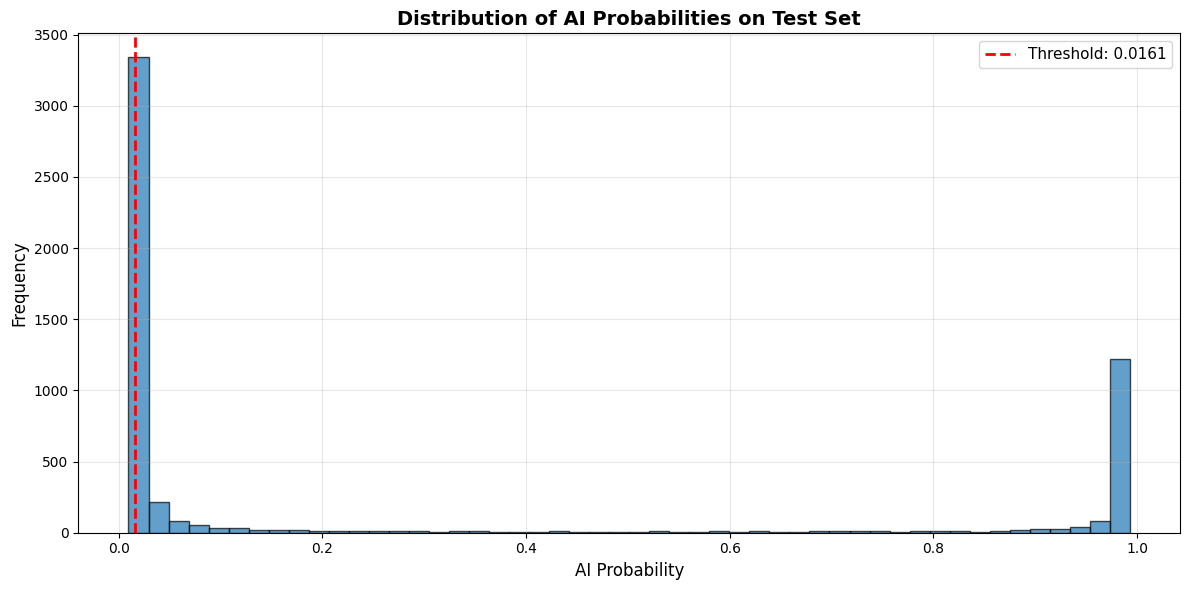


✓ Submission file saved to: final_submission.csv

Prediction Summary:
  Human images: 2770 (50.00%)
  AI images: 2770 (50.00%)

PIPELINE COMPLETE!


In [15]:
print("\n" + "="*60)
print("GENERATING SUBMISSION FILE")
print("="*60 + "\n")

USE_ADAPTIVE_THRESHOLD = True

probabilities_dataframe = pd.read_csv(probabilities_output_path)

if USE_ADAPTIVE_THRESHOLD:
    # Use median as threshold for balanced predictions
    threshold_value = probabilities_dataframe['ai_probability'].median()
    print(f"Using adaptive threshold (median): {threshold_value:.4f}")
else:
    threshold_value = 0.5
    print(f"Using fixed threshold: {threshold_value}")

# Visualize probability distribution
plt.figure(figsize=(12, 6))
plt.hist(probabilities_dataframe['ai_probability'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(threshold_value, color='red', linestyle='--', linewidth=2, 
            label=f'Threshold: {threshold_value:.4f}')
plt.xlabel('AI Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of AI Probabilities on Test Set', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Generate submission file
submission_dataframe = probabilities_dataframe.copy()
submission_dataframe['label'] = (submission_dataframe['ai_probability'] > threshold_value).astype(int)

submission_output_path = "final_submission.csv"
submission_dataframe[['id', 'label']].to_csv(submission_output_path, index=False)

print(f"\n✓ Submission file saved to: {submission_output_path}")

# Display prediction statistics
num_human_predictions = (submission_dataframe['label'] == 0).sum()
num_ai_predictions = (submission_dataframe['label'] == 1).sum()

print(f"\nPrediction Summary:")
print(f"  Human images: {num_human_predictions} ({num_human_predictions/len(submission_dataframe)*100:.2f}%)")
print(f"  AI images: {num_ai_predictions} ({num_ai_predictions/len(submission_dataframe)*100:.2f}%)")

print("\n" + "="*60)
print("PIPELINE COMPLETE!")
print("="*60)